Starting hyperparameter tuning...
New best model found - CV Score: 0.7445, Params: {'solver': 'lbfgs', 'C': np.float64(0.001), 'max_iter': 50, 'tol': 0.0001}
New best model found - CV Score: 0.7446, Params: {'solver': 'lbfgs', 'C': np.float64(0.001), 'max_iter': 50, 'tol': 0.001}
New best model found - CV Score: 0.7637, Params: {'solver': 'lbfgs', 'C': np.float64(0.01), 'max_iter': 50, 'tol': 0.0001}
New best model found - CV Score: 0.7640, Params: {'solver': 'lbfgs', 'C': np.float64(0.01), 'max_iter': 50, 'tol': 0.001}
New best model found - CV Score: 0.7769, Params: {'solver': 'lbfgs', 'C': np.float64(0.1), 'max_iter': 50, 'tol': 0.0001}
New best model found - CV Score: 0.7806, Params: {'solver': 'lbfgs', 'C': np.float64(1.0), 'max_iter': 50, 'tol': 0.0001}
New best model found - CV Score: 0.7810, Params: {'solver': 'lbfgs', 'C': np.float64(10.0), 'max_iter': 50, 'tol': 0.0001}
New best model found - CV Score: 0.7818, Params: {'solver': 'lbfgs', 'C': np.float64(10.0), 'max_iter': 50,

C:\Users\huangm\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\huangm\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\huangm\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\huangm\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\huangm\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\huangm\AppData\Local\anaco

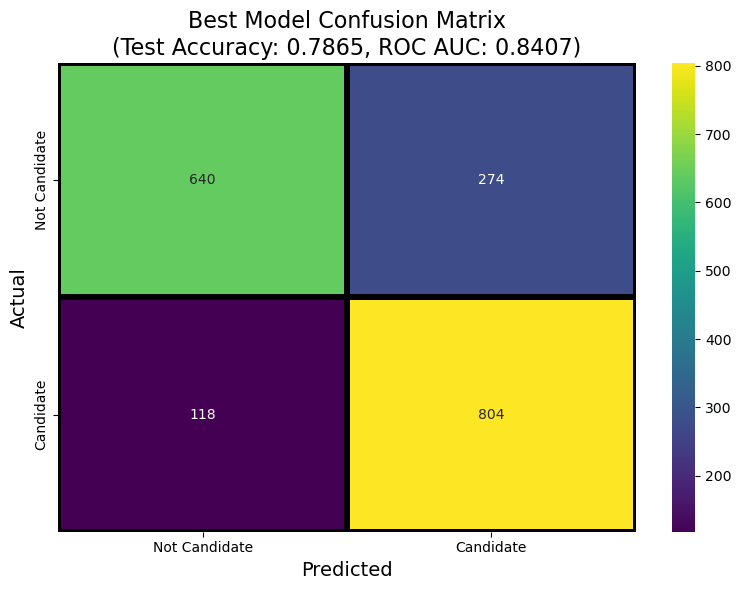


=== Best Model Summary ===
Best Parameters: {'solver': 'lbfgs', 'C': np.float64(10.0), 'max_iter': 50, 'tol': 0.001}
Cross-Validation Accuracy: 0.7818
Test Accuracy: 0.7865
ROC AUC Score: 0.8407

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.70      0.77       914
           1       0.75      0.87      0.80       922

    accuracy                           0.79      1836
   macro avg       0.80      0.79      0.78      1836
weighted avg       0.79      0.79      0.78      1836


Feature Coefficients:
        Feature  Coefficient
9      koi_smet     0.545155
5     koi_insol     0.294720
0    koi_period    -0.017099
3      koi_prad    -0.044438
6     koi_steff    -0.079365
8      koi_srad    -0.181379
7     koi_slogg    -0.213233
1  koi_duration    -0.898122
4       koi_teq    -1.400850
2     koi_depth    -6.124884


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load and preprocess data
short_cols = ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad',
              'koi_teq', 'koi_insol', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smet', 'ExoplanetCandidate']

data = pd.read_csv('KOI_cumulative_2025.07.31_21.17.09.csv', comment='#')
data['ExoplanetCandidate'] = data['koi_pdisposition'].apply(lambda x: 1 if x == 'CANDIDATE' else 0)
data = data[short_cols].dropna()
data.to_csv('KOI_2025.07.31_cleaned.csv')

# Prepare features and target
X = data.drop(columns=['ExoplanetCandidate'])
y = data['ExoplanetCandidate']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.2, stratify=y)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
joblib.dump(scaler, 'scaler_ksmet.sav')

# Initialize variables for best model tracking
best_model = None
best_score = -1  # Initialize to lowest possible value
best_params = {}
results = []

# Parameter ranges to test
c_range = np.logspace(-3, 3, 7)  # Logarithmic scale for C
max_iter_range = [50, 100, 200]
tol_range = [1e-4, 1e-3, 1e-2]
solvers = ['lbfgs', 'liblinear', 'saga']

# Nested loop for hyperparameter tuning
print("Starting hyperparameter tuning...")
for solver in solvers:
    for c in c_range:
        for max_iter in max_iter_range:
            for tol in tol_range:
                
                try:
                    # Create and evaluate model
                    model = LogisticRegression(
                        C=c,
                        max_iter=max_iter,
                        tol=tol,
                        solver=solver,
                        class_weight='balanced',
                        random_state=10
                    )
                    
                    # Cross-validation
                    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
                    mean_cv = np.mean(cv_scores)
                    
                    # Track results
                    results.append({
                        'solver': solver,
                        'C': c,
                        'max_iter': max_iter,
                        'tol': tol,
                        'cv_score': mean_cv
                    })
                    
                    # Update best model
                    if mean_cv > best_score:
                        best_score = mean_cv
                        best_model = model
                        best_params = {
                            'solver': solver,
                            'C': c,
                            'max_iter': max_iter,
                            'tol': tol
                        }
                        print(f"New best model found - CV Score: {best_score:.4f}, Params: {best_params}")
                
                except Exception as e:
                    print(f"Skipping combination - Solver: {solver}, C: {c}, max_iter: {max_iter}, tol: {tol} - Error: {str(e)}")

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv('LR_hyperparameter_tuning_results.csv', index=False)

# Train best model on full training data
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'best_tuned_lr_model.sav')

# Evaluate on test set
test_score = best_model.score(X_test, y_test)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Generate and show only the final confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="viridis", fmt="d", 
            linecolor="k", linewidths=3,
            xticklabels=['Not Candidate', 'Candidate'],
            yticklabels=['Not Candidate', 'Candidate'])
plt.title(f"Best Model Confusion Matrix\n(Test Accuracy: {test_score:.4f}, ROC AUC: {roc_auc_score(y_test, y_proba):.4f})", fontsize=16)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Actual", fontsize=14)
plt.tight_layout()
plt.savefig('LR_best_model_confusion_matrix.png')
plt.show()

# Print final model summary
print("\n=== Best Model Summary ===")
print(f"Best Parameters: {best_params}")
print(f"Cross-Validation Accuracy: {best_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nFeature Coefficients:")
print(pd.DataFrame({'Feature': X.columns, 'Coefficient': best_model.coef_[0]}).sort_values('Coefficient', ascending=False))

Top Performing Configuration:
solver    C  max_iter   tol  cv_score
 lbfgs 10.0        50 0.001  0.781804


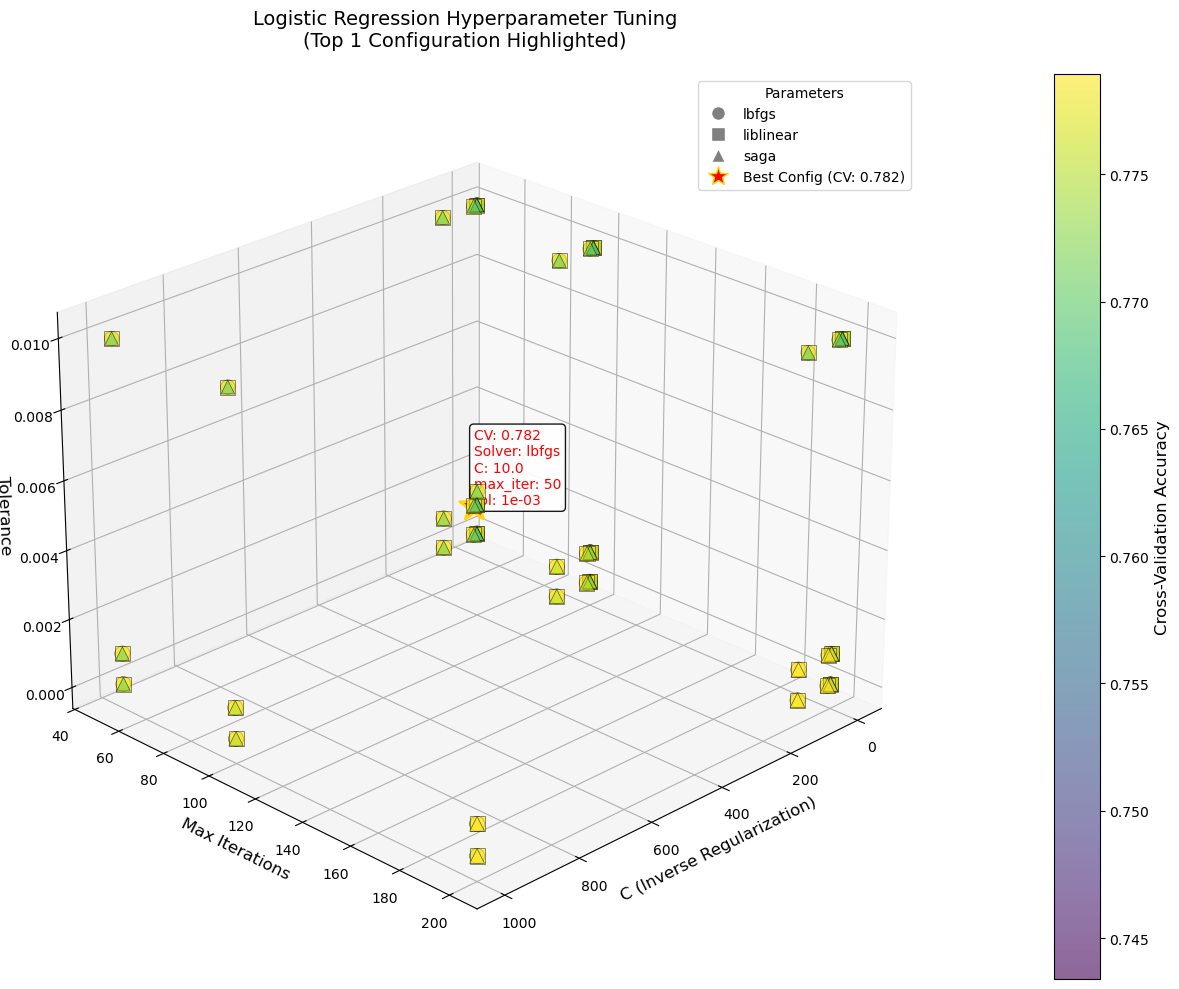

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.lines import Line2D

# Load data
df = pd.read_csv('LR_hyperparameter_tuning_results.csv')

# Get top 1 configuration
top1 = df.nlargest(1, 'cv_score')
print("Top Performing Configuration:")
print(top1[['solver', 'C', 'max_iter', 'tol', 'cv_score']].to_string(index=False))

# Map solvers to shapes and base colors
solver_mapping = {
    'lbfgs': {'marker': 'o', 'color': '#1f77b4'},
    'liblinear': {'marker': 's', 'color': '#ff7f0e'},
    'saga': {'marker': '^', 'color': '#2ca02c'}
}

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot all points (colored by CV score)
for solver, props in solver_mapping.items():
    mask = df['solver'] == solver
    sc = ax.scatter(
        df.loc[mask, 'C'],
        df.loc[mask, 'max_iter'],
        df.loc[mask, 'tol'],
        c=df.loc[mask, 'cv_score'],
        cmap='viridis',
        marker=props['marker'],
        s=40 + 80*(df.loc[mask, 'cv_score'] - df['cv_score'].min())/(df['cv_score'].max() - df['cv_score'].min()),
        alpha=0.6,
        edgecolor='k',
        linewidth=0.5,
        label=solver
    )

# Highlight ONLY the top 1 point in red
ax.scatter(
    top1['C'],
    top1['max_iter'],
    top1['tol'],
    c='red',
    marker='*',
    s=500,  # Extra large size
    edgecolor='gold',
    linewidth=2,
    alpha=1,
    label=f'Best (CV: {top1["cv_score"].values[0]:.3f})',
    zorder=10
)

# Add detailed label to top point
ax.text(top1['C'].values[0], 
        top1['max_iter'].values[0], 
        top1['tol'].values[0]*1.05,
        f"CV: {top1['cv_score'].values[0]:.3f}\n"
        f"Solver: {top1['solver'].values[0]}\n"
        f"C: {top1['C'].values[0]:.1f}\n"
        f"max_iter: {top1['max_iter'].values[0]}\n"
        f"tol: {top1['tol'].values[0]:.0e}",
        color='red',
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.9, boxstyle='round'))

# Colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Cross-Validation Accuracy', fontsize=12)

# Custom legend
legend_elements = [
    *[Line2D([0], [0],
             marker=props['marker'],
             color='w',
             markerfacecolor='gray',
             markersize=10,
             label=solver) for solver, props in solver_mapping.items()],
    Line2D([0], [0],
           marker='*',
           color='w',
           markerfacecolor='red',
           markeredgecolor='gold',
           markersize=15,
           label=f'Best Config (CV: {top1["cv_score"].values[0]:.3f})')
]

ax.legend(handles=legend_elements, title='Parameters', loc='upper right')

# Axis labels
ax.set_xlabel('C (Inverse Regularization)', fontsize=12)
ax.set_ylabel('Max Iterations', fontsize=12)
ax.set_zlabel('Tolerance', fontsize=12)

# Title
plt.title('Logistic Regression Hyperparameter Tuning\n(Top 1 Configuration Highlighted)', 
          fontsize=14, pad=20)

# Adjust view
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.savefig('LR_Top1_Configuration.png', dpi=300, bbox_inches='tight')
plt.show()

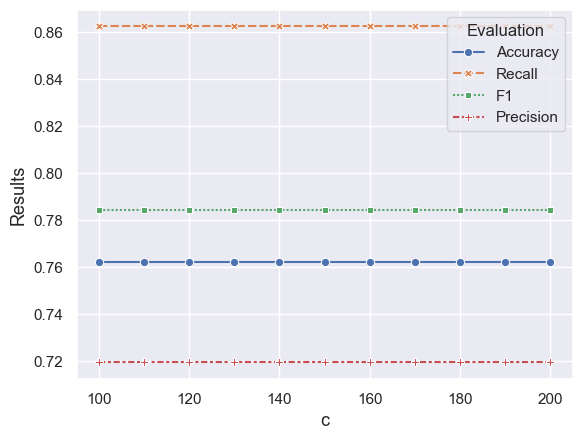

In [32]:
df_melted = df.melt('c', ['Accuracy','Recall','F1', 'Precision'], var_name='Evaluation', value_name='Results')
df_melted.columns.values[0] = 'c'
df_melted.head()
ax = sns.lineplot(data=df_melted, x='c', y='Results', hue='Evaluation', style='Evaluation', markers=True)
ax.set_xlabel('c', fontsize=13)
ax.set_ylabel('Results', fontsize=13)
#ax.set_ylim(0.82, 0.88)
plt.savefig('logreg.pdf')